# Notebook 2.1: System Identification for LMPC (Simple Example)

Model Predictive Control relies fundamentally on a model of the process to be controlled. While sometimes these models come from first principles (physics, chemistry, biology), often they are derived from experimental input-output data through a process called **System Identification (SysID)**.

For Linear MPC (LMPC), we typically need a discrete-time linear model, often in state-space form. This notebook provides a simplified introduction to system identification, demonstrating how to obtain such a model from simulated noisy data.

**Goals of this Notebook:**
1. Understand the basic workflow of system identification.
2. Generate input-output data from a known "true" system with added noise.
3. Apply a simple system identification technique (focusing on least squares for an ARX-like structure or a simple state-space parameter estimation for a known order).
4. Validate the identified model by comparing its predictions or step response to the true system.
5. Discuss the importance of excitation, data quality, and model validation.

## 1. Importing Libraries

We'll use NumPy, Matplotlib, and SciPy. For system identification, SciPy offers some tools, and for more advanced methods, libraries like `python-control` or dedicated SysID packages might be used (though we'll keep it simpler here).

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete, lsim, step, dstep, impulse, dimpulse
from scipy.linalg import lstsq # For least squares solution

# Optional: for nicer plots
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

## 2. The "True" System and Data Generation

First, let's define a "true" system whose model we want to identify. In a real scenario, this would be an actual physical process. Here, we'll use a known LTI system so we can later compare our identified model against the truth.

Let's use a second-order continuous-time system (e.g., a mass-spring-damper).

In [7]:
# True Continuous-Time System (e.g., mass-spring-damper)
m_true = 1.0  # mass
k_true = 2.0  # spring constant
b_true = 0.5  # damping coefficient

Ac_true = np.array([[0, 1], 
                    [-k_true/m_true, -b_true/m_true]])
Bc_true = np.array([[0], 
                    [1/m_true]])
Cc_true = np.array([[1, 0]]) # Output is position
Dc_true = np.array([[0]])

Ts_id = 0.1 # Sampling time for identification

# Discretize the true system
Ad_true, Bd_true, Cd_true, Dd_true, _ = cont2discrete((Ac_true, Bc_true, Cc_true, Dc_true), Ts_id, method='zoh')

print("True Discrete A:\n", Ad_true)
print("\nTrue Discrete B:\n", Bd_true)

True Discrete A:
 [[ 0.99018093  0.09721635]
 [-0.1944327   0.94157275]]

True Discrete B:
 [[0.00490953]
 [0.09721635]]


### Generating Input-Output Data

To identify a model, we need to excite the system with a suitable input signal and record its output. The input signal should be **persistently exciting**, meaning it contains enough frequencies to reveal the system's dynamics.

A common choice for identification is a **Pseudo-Random Binary Sequence (PRBS)** or a signal with broad frequency content.

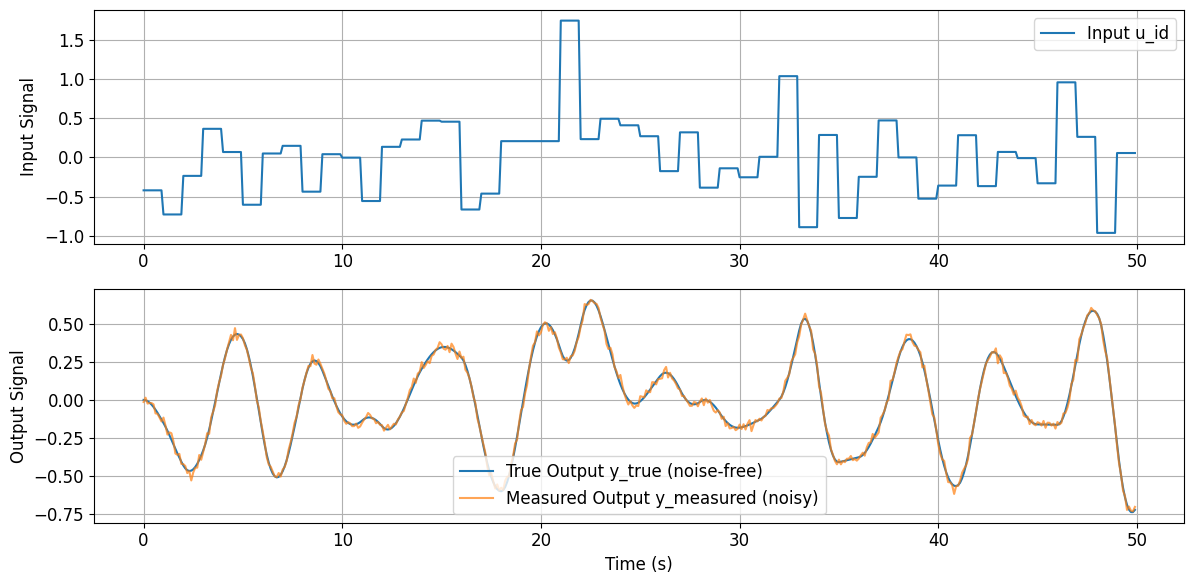

In [8]:
N_id_points = 500 # Number of data points for identification
t_id = np.arange(0, N_id_points * Ts_id, Ts_id)

# Generate a PRBS-like input signal
np.random.seed(42) # for reproducibility
u_id = np.random.choice([-1, 1], N_id_points) * 0.5 # Random steps between -0.5 and 0.5
# More sophisticated PRBS generation could be used, or a swept-sine, etc.
# For simplicity, we'll use random steps. Let's make it change less frequently
u_id_raw = np.random.randn(N_id_points // 10) 
u_id = np.repeat(u_id_raw, 10)[:N_id_points] 
u_id = (u_id - np.mean(u_id)) / np.std(u_id) * 0.5 # Normalize and scale

# Simulate the true system to get output data
x_id_true = np.zeros((Ad_true.shape[0], N_id_points + 1))
y_id_true_noisefree = np.zeros((Cd_true.shape[0], N_id_points))

x_curr = np.array([[0.0], [0.0]]) # Initial state
x_id_true[:, 0] = x_curr.flatten()

for k in range(N_id_points):
    y_id_true_noisefree[:, k] = (Cd_true @ x_curr + Dd_true * u_id[k]).flatten()
    x_curr = Ad_true @ x_curr + Bd_true * u_id[k]
    x_id_true[:, k+1] = x_curr.flatten()

# Add measurement noise
noise_std_dev = 0.02
measurement_noise = np.random.normal(0, noise_std_dev, y_id_true_noisefree.shape)
y_id_measured = y_id_true_noisefree + measurement_noise

# Plot the identification data
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t_id, u_id, label='Input u_id')
plt.ylabel('Input Signal')
plt.grid(True); plt.legend()

plt.subplot(2,1,2)
plt.plot(t_id, y_id_true_noisefree.T, label='True Output y_true (noise-free)')
plt.plot(t_id, y_id_measured.T, alpha=0.7, label='Measured Output y_measured (noisy)')
plt.ylabel('Output Signal')
plt.xlabel('Time (s)')
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

## 3. System Identification: A Simple ARX Model Example

We'll try to identify an ARX (AutoRegressive with eXternal input) model. For a SISO system, it has the form:
$ y_k + a_1 y_{k-1} + \dots + a_{n_a} y_{k-n_a} = b_0 u_{k-d} + b_1 u_{k-d-1} + \dots + b_{n_b} u_{k-d-n_b} + e_k $
where $d$ is the input delay (number of samples).

This can be written as a linear regression problem: $y_k = \phi_k^T \theta + e_k$, where $\phi_k$ is a vector of past inputs and outputs (regressor vector) and $\theta$ is the vector of unknown parameters ($a_i, b_i$).

For our 2nd order system, let's try to fit a model like:
$y_k = -a_1 y_{k-1} - a_2 y_{k-2} + b_1 u_{k-1} + b_2 u_{k-2}$ (assuming delay $d=1$ for $b_1$)

$\theta = [-a_1, -a_2, b_1, b_2]^T$
$\phi_k = [y_{k-1}, y_{k-2}, u_{k-1}, u_{k-2}]^T$

We stack these to form $\mathbf{Y} = \mathbf{\Phi} \theta$, and solve for $\theta$ using least squares: $\theta = (\mathbf{\Phi}^T \mathbf{\Phi})^{-1} \mathbf{\Phi}^T \mathbf{Y}$.

In [9]:
# System Identification using ARX structure (simple least squares)
na = 2 # Order of A polynomial (number of past y's)
nb = 2 # Order of B polynomial (number of past u's)
nk = 1 # Input delay (u_k-nk)

# Prepare data for regression
# We need to predict y_k from y_k-1, y_k-2, u_k-1, u_k-2 (if nk=1)
num_data_points_for_regression = N_id_points - max(na, nb + nk -1)
Y_target_regression = np.zeros((num_data_points_for_regression, 1))
Phi_regressor_matrix = np.zeros((num_data_points_for_regression, na + nb))

for i in range(num_data_points_for_regression):
    k = max(na, nb + nk - 1) + i # Current time index in original data
    
    Y_target_regression[i] = y_id_measured[0, k] # y_k (assuming SISO for y_id_measured)
    
    regressor_row = []
    # Past outputs: -y_k-1, -y_k-2 ... (for a_i terms on LHS)
    for j in range(na):
        regressor_row.append(-y_id_measured[0, k - (j + 1)])
    # Past inputs: u_k-nk, u_k-nk-1 ... 
    for j in range(nb):
        regressor_row.append(u_id[k - nk - j])
    Phi_regressor_matrix[i, :] = regressor_row

# Solve for parameters theta using least squares
theta_hat, residuals, rank, singular_values = lstsq(Phi_regressor_matrix, Y_target_regression)

print("Identified ARX parameters (theta_hat):")
print(theta_hat)

a_hat_params = -theta_hat[0:na] # a_i = -theta_i for i=0..na-1
b_hat_params = theta_hat[na:na+nb]

print("\nEstimated 'a' coefficients (for A(q)y = ...):", [1] + list(a_hat_params.flatten()))
print("Estimated 'b' coefficients (for B(q)u = ...):", list(b_hat_params.flatten()))

Identified ARX parameters (theta_hat):
[[-1.3431144 ]
 [ 0.3700376 ]
 [-0.00408822]
 [ 0.03431662]]

Estimated 'a' coefficients (for A(q)y = ...): [1, np.float64(1.3431143997345427), np.float64(-0.3700376048744757)]
Estimated 'b' coefficients (for B(q)u = ...): [np.float64(-0.004088223504539648), np.float64(0.03431661779072967)]


### Converting ARX to State-Space (Conceptual)

An identified ARX model can be converted to a state-space representation. For example, using controllable canonical form. Libraries like `python-control` offer functions for this (`tf2ss`). For simplicity here, we'll simulate directly using the ARX difference equation for validation, but for MPC, we'd typically want the state-space form $A_{id}, B_{id}, C_{id}, D_{id}$.

## 4. Model Validation

Validation is crucial! We need to check if our identified model can predict the system's behavior on data it hasn't seen during training (or at least how well it fits the training data if no separate validation set is used here).

#### 4.1 Simulating the Identified ARX Model


Identified TF Denominator (A(q) coeffs): [ 1.         1.3431144 -0.3700376]
Identified TF Numerator (B(q) coeffs with delay): [ 0.         -0.00408822  0.03431662]


/tmp/ipykernel_6003/1048841316.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_arx[k] = current_y_pred # .item() if it's a 1x1 array
/home/tensor/Model_predictive_control/.venv/lib/python3.12/site-packages/scipy/signal/_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


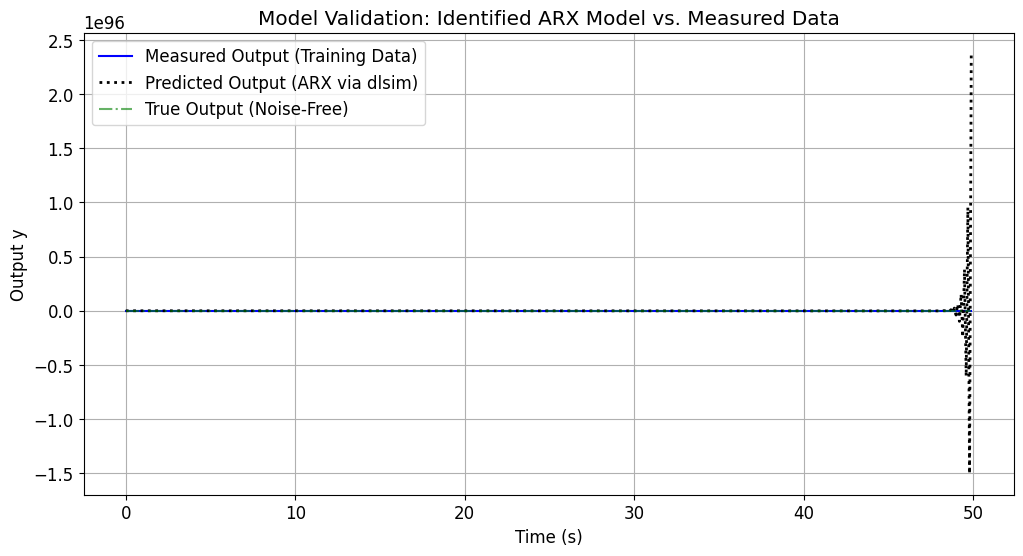


Variance Accounted For (VAF) by ARX model: -20220724142505044377645430227070001039826865086169614258019865219594029151053462522697650817661417787134343921588431069033320505985234753155949595390337979864676652446405590173312877036981714944.00%


In [10]:
# Simulate the identified ARX model using the same u_id input
y_pred_arx = np.zeros(N_id_points)

# Initial conditions for past y and u needed for ARX simulation
past_y = np.zeros(na)
past_u = np.zeros(nb + nk -1) # Max memory for u needed is nb terms starting from u_k-nk

for k in range(N_id_points):
    current_y_pred = 0
    # Contribution from past y's
    for i in range(na):
        if k - (i + 1) >= 0: # Use actual past y from simulation if available
            # For pure simulation from parameters, use past_y values
            current_y_pred += -a_hat_params[i] * (y_pred_arx[k-(i+1)] if k-(i+1)>=0 else 0) # Simulating identified model
        # else: use 0 for initial past_y values (implicitly handled if y_pred_arx is initialized to 0)
            
    # Contribution from past u's
    for i in range(nb):
        if k - nk - i >= 0:
            current_y_pred += b_hat_params[i] * u_id[k - nk - i]
            
    y_pred_arx[k] = current_y_pred # .item() if it's a 1x1 array

# A better way to simulate ARX from identified parameters is often using scipy.signal.dlsim
# if we convert ARX to transfer function (num_b, den_a) then to state-space.
# Denominator for TF: [1, a1_hat, a2_hat, ...]
# Numerator for TF: [0 (for nk=1), b1_hat, b2_hat, ...]
den_a_tf = np.concatenate(([1], a_hat_params.flatten()))
num_b_tf = np.zeros(nk + nb)
num_b_tf[nk:nk+nb] = b_hat_params.flatten()

print("\nIdentified TF Denominator (A(q) coeffs):", den_a_tf)
print("Identified TF Numerator (B(q) coeffs with delay):", num_b_tf)

try:
    # Simulate using dlsim
    # dlsim needs a discrete-time system tuple (num, den, dt) or (A,B,C,D,dt)
    # For a transfer function (num, den, dt)
    system_identified_tf = (num_b_tf, den_a_tf, Ts_id)
    t_sim_dlsim, y_pred_dlsim, x_pred_dlsim = lsim(system_identified_tf, U=u_id, T=t_id)
    # Note: lsim is for continuous, dstep/dimpulse/dlsim are for discrete.
    # Actually, for discrete TF, dlsim is what we need.
    from scipy.signal import dlsim
    tout_dlsim, y_pred_dlsim = dlsim(system_identified_tf, u=u_id, t=t_id)

    plt.figure(figsize=(12,6))
    plt.plot(t_id, y_id_measured[0,:], 'b-', label='Measured Output (Training Data)')
    #plt.plot(t_id, y_pred_arx, 'r--', alpha=0.8, label='Predicted Output (ARX Manual Sim)')
    plt.plot(tout_dlsim, y_pred_dlsim, 'k:', linewidth=2, label='Predicted Output (ARX via dlsim)')
    plt.plot(t_id, y_id_true_noisefree[0,:], 'g-.', alpha=0.6, label='True Output (Noise-Free)')
    plt.title('Model Validation: Identified ARX Model vs. Measured Data')
    plt.xlabel('Time (s)')
    plt.ylabel('Output y')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate a fit percentage (e.g., using Variance Accounted For - VAF)
    error = y_id_measured[0,:] - y_pred_dlsim.flatten()
    vaf = (1 - np.var(error) / np.var(y_id_measured[0,:])) * 100
    print(f"\nVariance Accounted For (VAF) by ARX model: {vaf:.2f}%")

except Exception as e:
    print(f"Error during dlsim or plotting: {e}")
    print("Manual ARX simulation results will be shown if dlsim failed.")
    plt.figure(figsize=(12,6))
    plt.plot(t_id, y_id_measured[0,:], 'b-', label='Measured Output (Training Data)')
    plt.plot(t_id, y_pred_arx, 'r--', alpha=0.8, label='Predicted Output (ARX Manual Sim)')
    plt.plot(t_id, y_id_true_noisefree[0,:], 'g-.', alpha=0.6, label='True Output (Noise-Free)')
    plt.title('Model Validation: Identified ARX Model vs. Measured Data (Manual Sim)')
    plt.xlabel('Time (s)')
    plt.ylabel('Output y')
    plt.legend()
    plt.grid(True)
    plt.show()

#### 4.2 Comparing Step Responses (Qualitative Validation)

Another way to validate is to compare the step response of the identified model with the true system's step response.

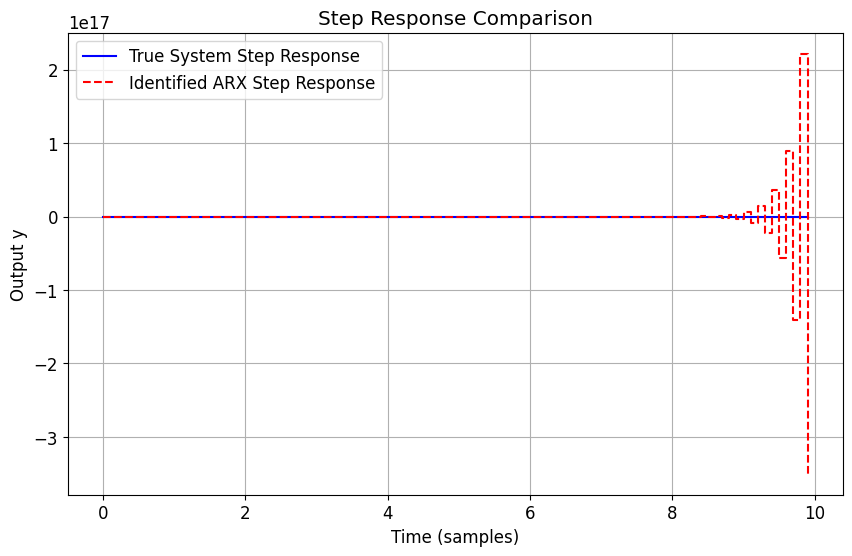

In [11]:
# True system step response (discrete)
t_step_true, y_step_true = dstep((Ad_true, Bd_true, Cd_true, Dd_true, Ts_id), n=100)

# Identified ARX model step response (discrete)
try:
    system_identified_tf_for_step = (num_b_tf, den_a_tf, Ts_id)
    t_step_id, y_step_id = dstep(system_identified_tf_for_step, n=100)

    plt.figure(figsize=(10,6))
    plt.step(t_step_true, y_step_true[0].flatten(), 'b-', where='post', label='True System Step Response')
    plt.step(t_step_id, y_step_id[0].flatten(), 'r--', where='post', label='Identified ARX Step Response')
    plt.title('Step Response Comparison')
    plt.xlabel('Time (samples)')
    plt.ylabel('Output y')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error during step response comparison: {e}")

## 5. Discussion: Importance of Good Data and Model Choices

*   **Input Excitation:** The quality of the identified model heavily depends on the input signal used for identification. If the input doesn't excite all relevant system dynamics (e.g., if it's too slow or too fast, or doesn't have enough frequency content), the model will be poor.
*   **Noise:** Measurement noise can corrupt the identification process. Longer datasets or better signal-to-noise ratios can help.
*   **Model Order Selection ($n_a, n_b, n_k$):** Choosing the correct model order is crucial. Underfitting (orders too low) means the model can't capture the dynamics. Overfitting (orders too high) means the model might fit noise and generalize poorly. Information criteria (AIC, BIC) or cross-validation are often used for this.
*   **Validation is Key:** Always validate your identified model on a separate dataset (cross-validation) if possible, or using different types of analysis (like step responses, frequency responses, residual analysis) to ensure it's a reasonable representation of the true system before using it for MPC design.
*   **State-Space vs. ARX:** While we used ARX for simplicity here, for MPC, a state-space model ($A_{id}, B_{id}, C_{id}, D_{id}$) is usually the desired end product. More advanced identification techniques like Subspace Identification (e.g., N4SID) directly estimate state-space models and are often preferred for MIMO systems.

This notebook provided a very basic glimpse. Real-world system identification is a rich field with many sophisticated techniques and considerations.

## 6. Key Takeaways

*   System identification is the process of building mathematical models from observed input-output data.
*   For LMPC, we aim to obtain a discrete-time linear model.
*   The quality of the identification experiment (especially input signal design) and data is critical.
*   Simple methods like least squares for ARX models can provide a starting point, but more advanced techniques exist.
*   Thorough model validation is essential before using an identified model for control design.

In the next notebook (**Notebook 2.2: The Kalman Filter for LMPC**), we will assume we have a good (or identified) linear model and focus on how to estimate its states when measurements are noisy.